## Libraries

In [2]:
from datasets import load_dataset

import pandas as pd
import numpy as np
import sklearn

import networkx as nx
from networkx.algorithms import bipartite

from collections import Counter
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

c:\Users\anncy\anaconda3\envs\dsa4263\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# https://huggingface.co/datasets/Nooha/cc_fraud_detection_dataset
ds = load_dataset("Nooha/cc_fraud_detection_dataset")
df = ds["train"].to_pandas() # convert to pandas dataframe

## Initial Dataset Overview

In [11]:
# Check data types 
print("\nDataset information:")
print(df.info())

# Check missing values
missing_values = df.isnull().sum()
print("\nMissing Values:")
print(missing_values[missing_values > 0] if missing_values.sum() > 0 else "No missing values found")

# no duplicated rows
print("\nDuplicated Values:")
print("Duplicated values found" if any(df.duplicated()) else "No duplicated values found")
print()

# Check overall statistics
print(df.describe())


Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2646694 entries, 0 to 2646693
Data columns (total 20 columns):
 #   Column      Dtype  
---  ------      -----  
 0   ssn         object 
 1   cc_num      int64  
 2   first       object 
 3   last        object 
 4   gender      object 
 5   city        object 
 6   state       object 
 7   zip         int64  
 8   city_pop    int64  
 9   job         object 
 10  dob         object 
 11  acct_num    int64  
 12  trans_num   object 
 13  trans_date  object 
 14  trans_time  object 
 15  unix_time   int64  
 16  category    object 
 17  amt         float64
 18  is_fraud    int64  
 19  merchant    object 
dtypes: float64(1), int64(6), object(13)
memory usage: 403.9+ MB
None

Missing Values:
No missing values found

Duplicated Values:
No duplicated values found

             cc_num           zip      city_pop      acct_num     unix_time  \
count  2.646694e+06  2.646694e+06  2.646694e+06  2.646694e+06  2.646694e+06  

## Data Preprocessing

In [12]:
df1 = df.copy()
df1 = df1.drop(['first', 'last'], axis=1) # drop first and last name columns

In [ ]:
# Convert date and time to appropriate data types
df1[['trans_date','dob']] = df1[['trans_date','dob']].apply(pd.to_datetime)
df1['trans_time'] = pd.to_datetime(df1['trans_time'], format='%H:%M:%S')

# Extract transaction time features
df1['hour'] = df1['trans_time'].dt.hour
df1['day_of_week'] = df1['trans_date'].dt.day_name()
df1['month'] = df1['trans_date'].dt.strftime('%Y-%m')
df1["trans_quarter"] = pd.PeriodIndex(df1['month'], freq='Q')
df1['year'] = df1['trans_date'].dt.year


# Calculate age at the time of the transaction
df1['age'] = (df1['trans_date'] - df1['dob']).dt.days / 365.25
df1['age_group'] = pd.cut(df1['age'], bins=range(0, 101, 10), right=False, 
                             labels=[f"{i}-{i+10}" for i in range(0, 100, 10)]) 

# Merge city and state columns
df1['city_state'] = df1['city'] + ', ' + df1['state']

# Clean `ssn` feature
df1['ssn']=df1['ssn'].str.replace('-','')
df1['ssn']=df1['ssn'].astype(int)

# Clean `merchant` feature
df1['merchant']=df1['merchant'].str.replace('fraud_','',regex=False)

In [ ]:
# Dataset after preprocessing
# df1.info()

### Helper functions

In [43]:
# Helper functions
def fraud_filter(cols):
    return df1[df1['is_fraud'] == 1].groupby(cols).size().reset_index(name='fraud_count')

def fraud_summary(df, col):
    print(f'Average fraud per {col}: {np.mean(df['fraud_count'])}')
    print(f'Median fraud per {col}: {np.median(df['fraud_count'])}')
    print(f'Standard deviation fraud per {col}: {np.std(df['fraud_count'])}')


## Data Exploration

In [ ]:
# Check unique values in categorical columns
categorical = []

print('Unique values count')
for f in df1.columns:
    feature = df1[f]

    print(f'{f} unique values: {feature.nunique()}')
    if feature.dtype == float or feature.dtype == '<M8[ns]':
        print(' Not categorical')
        continue
    # If the number of unique features is less than half, more likely to be categorical
    if feature.nunique() < len(df1)/2:
        categorical.append(f)
        if feature.nunique() < 10:
            print(f'    Unique values: {feature.unique()}')
        continue
    print(' Not categorical')

Unique values count
ssn unique values: 997
cc_num unique values: 997
gender unique values: 2
    Unique values: ['F' 'M']
city unique values: 741
state unique values: 51
zip unique values: 942
city_pop unique values: 787
job unique values: 420
dob unique values: 978
 Not categorical
acct_num unique values: 997
trans_num unique values: 2646694
 Not categorical
trans_date unique values: 1095
 Not categorical
trans_time unique values: 86400
 Not categorical
unix_time unique values: 2573660
 Not categorical
category unique values: 14
amt unique values: 70272
 Not categorical
is_fraud unique values: 2
    Unique values: [1 0]
merchant unique values: 648
hour unique values: 24
day_of_week unique values: 7
    Unique values: ['Saturday' 'Sunday' 'Thursday' 'Wednesday' 'Friday' 'Monday' 'Tuesday']
month unique values: 36
trans_quarter unique values: 12
age unique values: 30337
 Not categorical
age_group unique values: 9
    Unique values: ['30-40', '20-30', '40-50', '50-60', '60-70', '70-80', 

In [35]:
# Yearly transactions count: output looks evenly split
df1['year'].value_counts()

year
2023    884851
2022    882285
2021    879558
Name: count, dtype: int64

In [ ]:
# Check if any `ssn` is linked to multiple credit card numbers
creditcard_count = df1.groupby('ssn')['cc_num'].apply(set).reset_index()
print(creditcard_count[creditcard_count['cc_num'].apply(lambda x: len(x)>1)]) # result: 1 ssn linked to only 1 cc_num

## Fraudulent Label Analysis

#### Analysis Overview

In [38]:
# Summary statistics for fraudulent transactions
fraud_summarised = df1[df1['is_fraud'] == 1].describe()
print(fraud_summarised)

                ssn        cc_num           zip      city_pop  \
count  9.422000e+03  9.422000e+03   9422.000000  9.422000e+03   
mean   4.458670e+08  3.909210e+17  51318.872745  2.954356e+05   
min    1.280753e+06  6.040027e+10   1040.000000  1.410000e+02   
25%    2.064273e+08  3.897245e+13  27806.000000  1.718400e+04   
50%    4.653727e+08  3.506538e+15  48433.000000  5.922300e+04   
75%    6.642008e+08  4.506150e+15  77450.000000  2.398790e+05   
max    8.975991e+08  4.997335e+18  99701.000000  2.906700e+06   
std    2.595013e+08  1.265245e+18  29771.729243  5.808730e+05   

                                 dob      acct_num  \
count                           9422  9.422000e+03   
mean   1975-07-04 17:59:55.414986208  4.939769e+11   
min              1928-06-07 00:00:00  8.077997e+08   
25%              1961-09-07 00:00:00  2.443508e+11   
50%              1976-02-27 00:00:00  4.873495e+11   
75%              1992-04-08 00:00:00  7.486302e+11   
max              2008-10-14 00:00:00

Fraud Distribution:
is_fraud
0    2637272
1       9422
Name: count, dtype: int64
Fraud Rate: 0.0036 (0.36%)


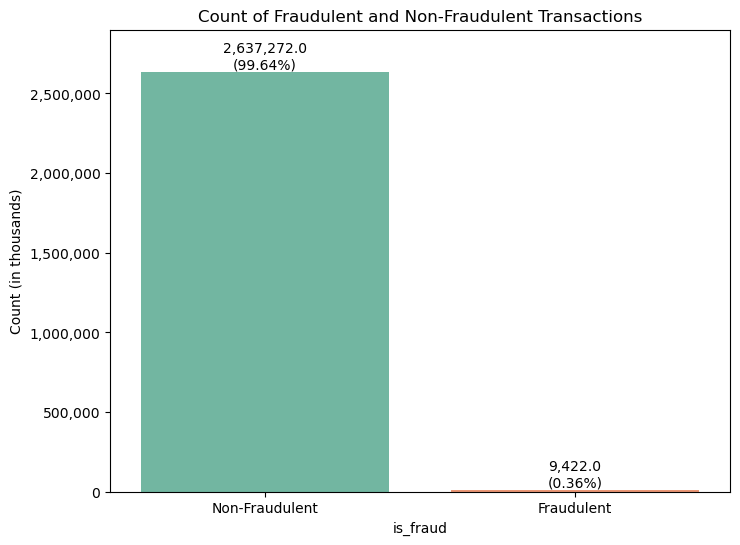

In [ ]:
# Fraud distribution
print("Fraud Distribution:")
fraud_counts = df1['is_fraud'].value_counts()
print(fraud_counts)

# Fraud rate
fraud_rate = df1['is_fraud'].mean()
print(f"Fraud Rate: {fraud_rate:.4f} ({fraud_rate * 100:.2f}%)")

plt.figure(figsize=(8, 6))
ax = sns.countplot(data=df, x='is_fraud', palette='Set2')

# Customize the plot
ax.set_ylabel('Count (in thousands)')
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))
ax.set_title('Count of Fraudulent and Non-Fraudulent Transactions')
ax.set_xticks([0, 1])  # Set x-ticks
ax.set_xticklabels(['Non-Fraudulent', 'Fraudulent'])  # Label x-axis

# Extend y-axis limits slightly for readability
plt.ylim(0, max(fraud_counts) * 1.1)
# Add count and percentage on the bars
total_count = len(df)
for p in ax.patches:
    height = p.get_height()
    percentage = (height / total_count) * 100
    ax.text(
        p.get_x() + p.get_width() / 2,  # X position (center of the bar)
        height + 1000,  # Y position (slightly above the bar)
        f'{height:,}\n({percentage:.2f}%)',  # Text (count and percentage)
        ha='center',  # Horizontal alignment
        va='bottom',  # Vertical alignment
        fontsize=10
    )

plt.show()

### Fraudulent transactions by hour

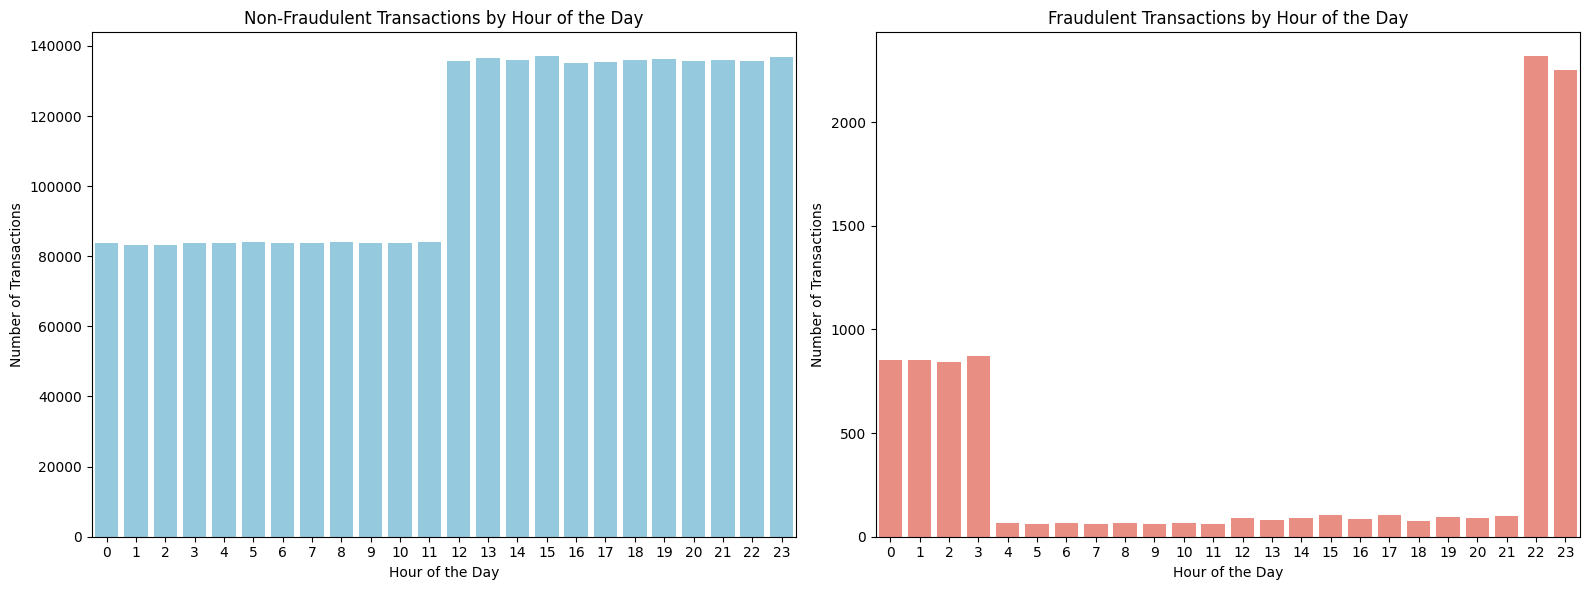

In [11]:
hour_fraud = df1.groupby(['hour', 'is_fraud']).size().unstack(fill_value=0)

# Create subplots for hour analysis
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot Non-Fraudulent Transactions by hour
sns.barplot(x=hour_fraud.index, y=hour_fraud[0], color='skyblue', ax=axes[0])
axes[0].set_title('Non-Fraudulent Transactions by Hour of the Day')
axes[0].set_xlabel('Hour of the Day')
axes[0].set_ylabel('Number of Transactions')

# Plot Fraudulent Transactions by hour
sns.barplot(x=hour_fraud.index, y=hour_fraud[1], color='salmon', ax=axes[1])
axes[1].set_title('Fraudulent Transactions by Hour of the Day')
axes[1].set_xlabel('Hour of the Day')
axes[1].set_ylabel('Number of Transactions')

plt.tight_layout()
plt.show()

In [37]:
# Group by unix_time and count transactions
time_grouped = df1.groupby('unix_time').agg(
    num_transactions=('trans_num', 'size'),
    num_unique_cards=('cc_num', 'nunique'),
    num_unique_merchants=('merchant', 'nunique'),
    num_fraud=('is_fraud', 'sum'),
).reset_index()

# Filter for times with multiple transactions
suspicious_times = time_grouped[time_grouped['num_transactions'] > 1].sort_values(by='num_transactions', ascending=False)

# Display the top 10 suspicious times
print("Top 10 Suspicious unix_time with multiple transactions:")
print(suspicious_times.head(10))

# results show that despite sharing unix_time, most of these transactions seem to be all unique and independent,
# hence unlikely to be coordinated fraud. Could be due to peak shopping times or other reasons.  

Top 10 Suspicious unix_time with multiple transactions:
          unix_time  num_transactions  num_unique_cards  num_unique_merchants  \
829445   1640427909                 5                 5                     5   
2299353  1695553714                 5                 5                     5   
2556003  1703772009                 5                 5                     5   
376979   1625265945                 4                 4                     4   
471629   1628374273                 4                 4                     4   
178987   1617998927                 4                 4                     4   
1215969  1656161807                 4                 4                     4   
558446   1631405689                 4                 4                     4   
343805   1624137368                 4                 4                     4   
491215   1628990684                 4                 4                     4   

         num_fraud  
829445           0  
2299353   

### Fraudulent transactions by date

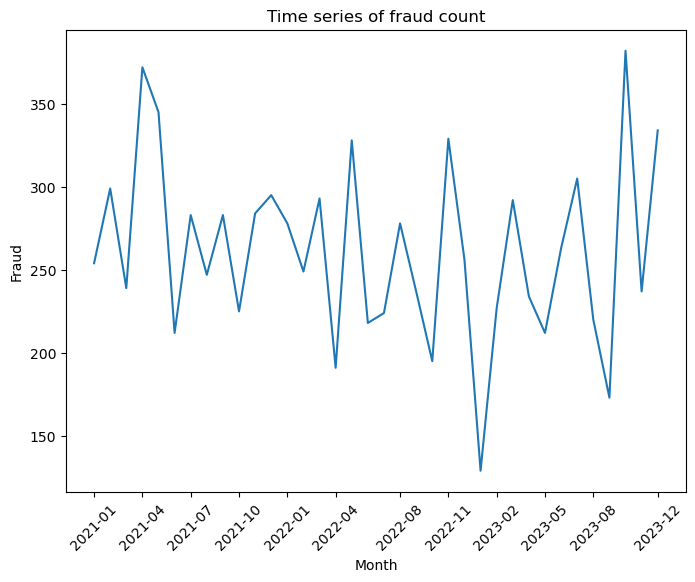

In [ ]:
# Overview of fraud counts by month
time_num_frauds = df1[["month", "is_fraud"]].groupby(by = "month", as_index = False).sum()

plt.figure(figsize=(8, 6))
plt.plot('month','is_fraud', data=time_num_frauds) 
plt.title('Time series of fraud count')
plt.xlabel('Month')
plt.ylabel('Fraud')
plt.xticks(time_num_frauds['month'][np.linspace(0, len(time_num_frauds) - 1, num=len(time_num_frauds[::3]), dtype=int)], rotation=45)
plt.show()

<Figure size 800x600 with 0 Axes>

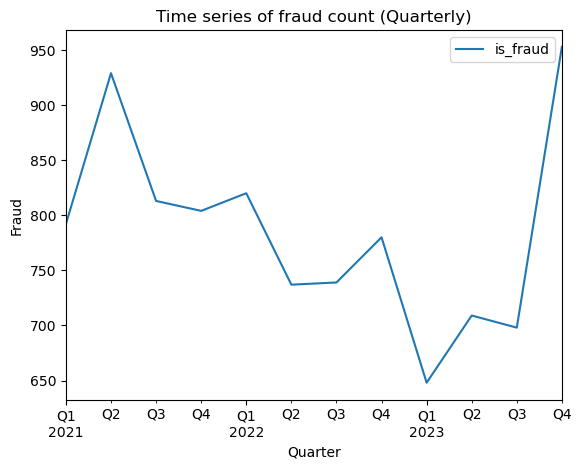

In [ ]:
# Fraud counts on quarterly basis
time_num_frauds = df1[["trans_quarter", "is_fraud"]].groupby(by = "trans_quarter").sum()

plt.figure(figsize=(8, 6))
time_num_frauds.plot()
plt.title('Time series of fraud count (Quarterly)')
plt.xlabel('Quarter')
plt.ylabel('Fraud')
plt.show()

C:\Users\anncy\AppData\Local\Temp\ipykernel_10396\723376522.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  time_num_frauds = df1[["trans_quarter", "is_fraud"]].groupby(by = "trans_quarter").apply(lambda x: x["is_fraud"].sum()/len(x))


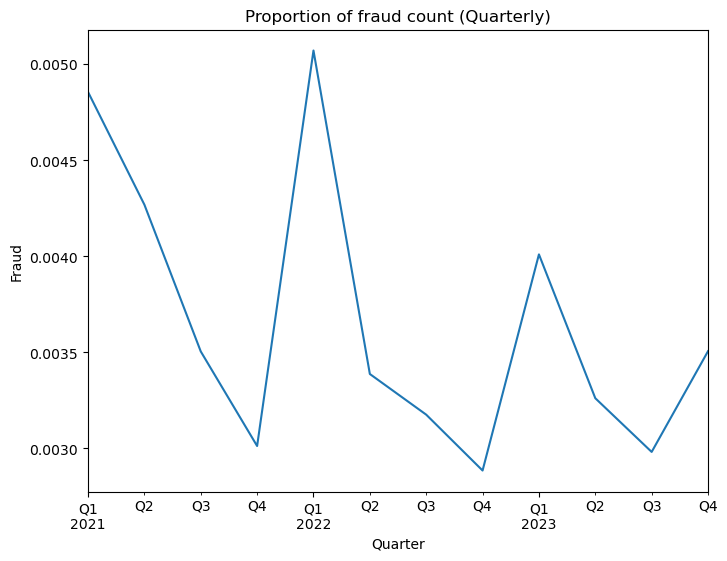

In [ ]:
# Proportion of fraud (quarterly)
time_num_frauds = df1[["trans_quarter", "is_fraud"]].groupby(by = "trans_quarter").apply(lambda x: x["is_fraud"].sum()/len(x))

plt.figure(figsize=(8, 6))
time_num_frauds.plot()
plt.title('Proportion of fraud count (Quarterly)')
plt.xlabel('Quarter')
plt.ylabel('Fraud')
plt.show()

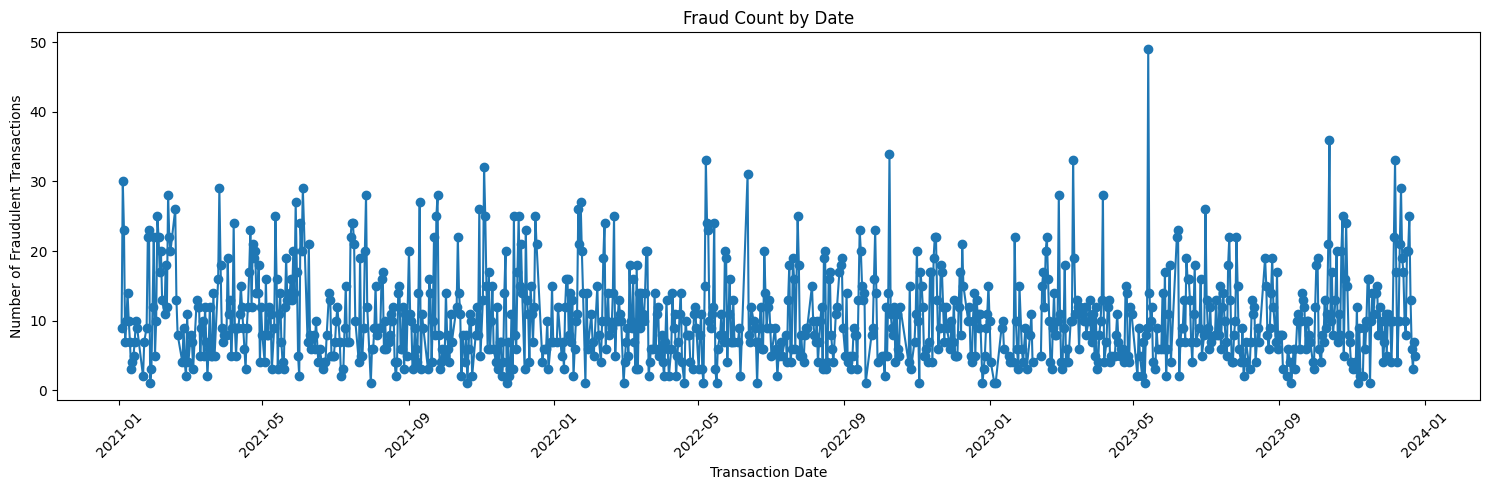

Dates with highest fraud:
    trans_date  fraud_count
713 2023-05-14           49
837 2023-10-13           36
540 2022-10-09           34
415 2022-05-08           33
659 2023-03-12           33
889 2023-12-07           33
255 2021-11-03           32
442 2022-06-12           31
1   2021-01-04           30
65  2021-03-26           29


In [12]:
fraud_count_by_date = fraud_filter('trans_date')

plt.figure(figsize=(15, 5))
plt.plot(fraud_count_by_date['trans_date'], fraud_count_by_date['fraud_count'], marker='o', linestyle='-')
plt.title('Fraud Count by Date')
plt.xlabel('Transaction Date')
plt.ylabel('Number of Fraudulent Transactions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Show dates with highest fraud
print("Dates with highest fraud:")
highest_fraud_dates = fraud_count_by_date.sort_values(by='fraud_count', ascending=False)
print(highest_fraud_dates.head(10))

**Unlikely that fraud is committed by duplicate transactions**

While there are non-negligible numbers of fraudulent transactions with duplicate time, there are relatively few cases associated with any customer or merchant.

In [48]:
# Check if there is fraud related to transaction time
unix_count = df1.groupby('unix_time')['unix_time'].count().reset_index(name='count').sort_values('count', ascending=False)
unix_count = unix_count[unix_count['count'] > 1]['unix_time']

duplicated_unix_time = df1[df1['unix_time'].isin(unix_count)].sort_values('unix_time')
duplicated_unix_time

,ssn,cc_num,gender,city,state,zip,city_pop,job,dob,acct_num,...,is_fraud,merchant,hour,day_of_week,month,trans_quarter,age,age_group,city_state,year
1058234,804928268,503871487271,F,Avon,CT,6001,18385,Music therapist,1988-06-17,308233949370,...,0,Cummings LLC,0,Friday,2021-01,2021Q1,32.542094,30-40,"Avon, CT",2021
2576115,24730528,4599996636186379,F,Dallas,TX,75252,1263321,Embryologist,2000-12-21,73869137112,...,0,Bins-Rice,0,Friday,2021-01,2021Q1,20.030116,20-30,"Dallas, TX",2021
984222,158908788,5573585730652407,M,Gibsonia,PA,15044,27049,Designer,2000-12-06,580116407639,...,0,Raynor,0,Friday,2021-01,2021Q1,20.071184,20-30,"Gibsonia, PA",2021
389317,568920313,213164931214636,F,Wickes,AR,71973,1424,Engineer,1966-05-25,118531854265,...,0,Christiansen,0,Friday,2021-01,2021Q1,54.606434,50-60,"Wickes, AR",2021
86591,813386608,30391900889913,F,Marietta,GA,30062,302309,Engineer,1985-06-17,502226927571,...,0,Cummings LLC,0,Friday,2021-01,2021Q1,35.542779,30-40,"Marietta, GA",2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2268502,310243661,373711222990773,M,Fort Worth,TX,76103,813980,Health promotion specialist,1974-06-29,611759212133,...,0,Hodkiewicz,23,Sunday,2023-12,2023Q4,49.505818,40-50,"Fort Worth, TX",2023
414092,69452671,4029295014372,F,Massapequa,NY,11758,53804,Therapist,2006-08-29,100931152672,...,0,Fritsch LLC,23,Sunday,2023-12,2023Q4,17.338809,10-20,"Massapequa, NY",2023
684163,869591502,4900532931839331,M,Dallas,TX,75252,1263321,Agricultural engineer,1988-02-27,13450992449,...,0,Kovacek Ltd,23,Sunday,2023-12,2023Q4,35.841205,30-40,"Dallas, TX",2023
1382692,206427252,4233222801944258926,M,Cleveland,OH,44126,769341,Artist,2000-04-12,429068169930,...,0,Corwin-Romaguera,23,Sunday,2023-12,2023Q4,23.718001,20-30,"Cleveland, OH",2023


In [ ]:
# Identify merchants with fraudulent transactions at duplicate times
fraud_duplicates_m = duplicated_unix_time[duplicated_unix_time['is_fraud'] == 1].groupby(['merchant'])['merchant'].count().reset_index(name='count')
fraud_duplicates_m = fraud_duplicates_m[fraud_duplicates_m['count'] > 1].sort_values('count', ascending=False)
fraud_duplicates_m.head(10)

,merchant,count
150,fraud_Reichert,8
156,fraud_Romaguera,5
140,fraud_O'Keefe-Hudson,4
141,fraud_Pacocha-O'Reilly,4
21,fraud_Boyer PLC,4
45,fraud_Fisher-Schowalter,4
31,fraud_Cormier LLC,3
51,fraud_Gerlach Inc,3
89,fraud_Jaskolski-Vandervort,3
85,fraud_Huel-Langworth,3


In [49]:
# Identify ssn with fraudulent transactions at duplicate times
fraud_duplicates_m = duplicated_unix_time[duplicated_unix_time['is_fraud'] == 1].groupby(['ssn'])['ssn'].count().reset_index(name='count')
fraud_duplicates_m = fraud_duplicates_m[fraud_duplicates_m['count'] > 1].sort_values('count', ascending=False)
fraud_duplicates_m.head(10)

,ssn,count
213,805105003,4
128,486855972,3
169,645243054,3
234,883641316,3
231,872212853,3
126,477507101,3
104,404227265,3
26,86372495,3
2,11788315,2
59,255195413,2


### Fraudulent transactions by location

C:\Users\Chloe\AppData\Local\Temp\ipykernel_39372\3024622567.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(summary['state'], fontsize=8)


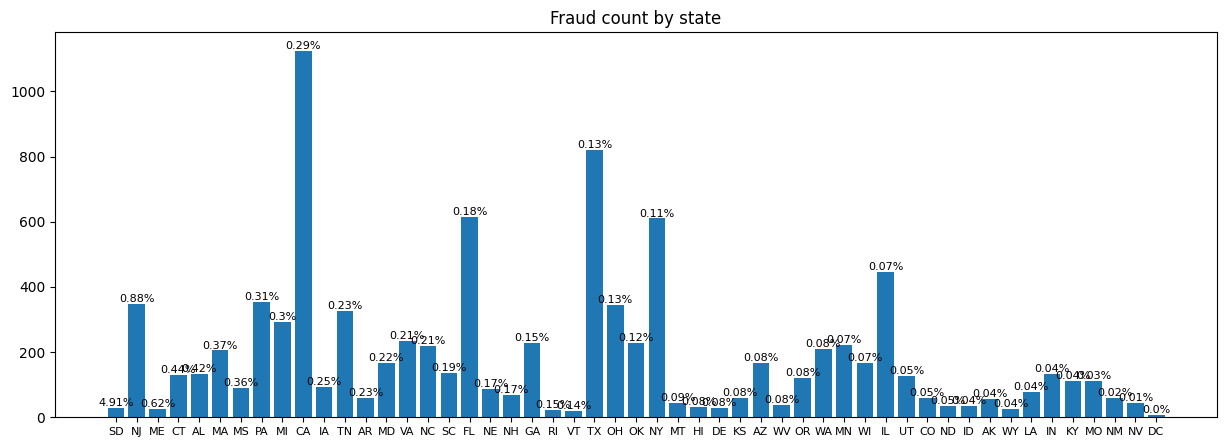

In [ ]:
# Total and proportion of fraud by state
fraud_count_by_state = fraud_filter('state')
pop = df1.groupby('state')['city_pop'].mean().reset_index(name='mean_pop')

summary = fraud_count_by_state.merge(pop, on='state')
summary['percentage'] = round(summary['fraud_count']/summary['mean_pop']*100, 2)
summary = summary.sort_values(by='percentage', ascending=False)

fig, ax = plt.subplots(figsize=(15,5))

ax.bar(summary['state'], summary['fraud_count'])
ax.set_title('Fraud count by state')
ax.set_xticklabels(summary['state'], fontsize=8)

for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.annotate(f'{summary["percentage"].iloc[i]}%', 
                (p.get_x() + p.get_width() / 2, height), 
                ha='center', va='bottom', fontsize=8)

plt.show()

**Higher population leads to higher number of fraud cases**

May be because it is easier to commit fraud in a large city.

From the data, it shows that cities with a larger population leads to greater number of frauds from the best fit line.

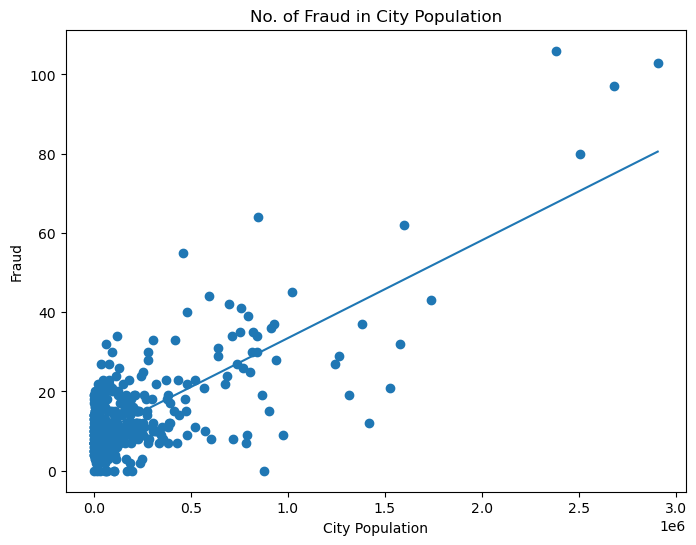

In [39]:
# Fraud count per city_pop. 
# Check if higher population leads to higher fraud cases
fraud_count = df1.groupby('city_pop')['is_fraud'].sum().reset_index()

a, b = np.polyfit(fraud_count["city_pop"], fraud_count["is_fraud"], 1)

plt.figure(figsize=(8, 6))
plt.scatter('city_pop','is_fraud', data=fraud_count)
plt.plot(fraud_count["city_pop"], a * fraud_count["city_pop"] + b)
plt.title('No. of Fraud in City Population')
plt.xlabel('City Population')
plt.ylabel('Fraud')
plt.show()

**Some cities are more popular for committing fraud**

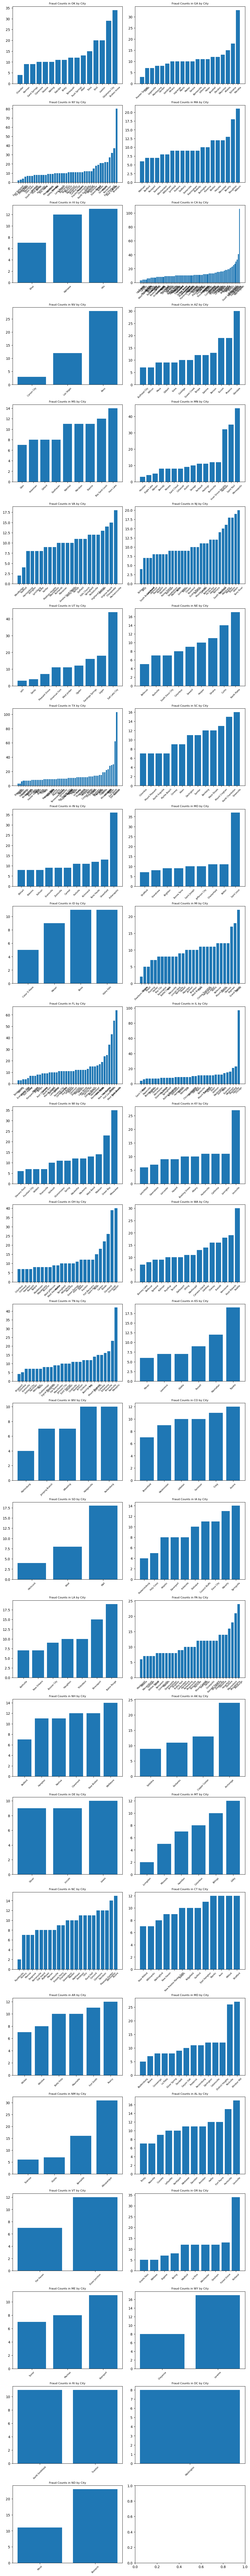

In [ ]:
# Fraud count per city per state
fraud_count_by_city = fraud_filter(['state', 'city'])

states = list(df1['state'].unique())
n = len(states)

fig, ax = plt.subplots(n//2+1, 2, figsize=(10, 4*(n//2+1)), constrained_layout=True)

ax = ax.flatten()
for i, state in enumerate(states):
    temp = fraud_count_by_city[fraud_count_by_city['state'] == state].sort_values(by='fraud_count')

    ax[i].bar(temp['city'], temp['fraud_count'])
    ax[i].set_title(f'Fraud Counts in {state} by City', fontsize=8)
    ax[i].tick_params(axis='x', rotation=45, labelsize=6)

plt.show()

In [15]:
# City-level analysis across states
fraud_count_by_city = fraud_filter(['state', 'city'])
fraud_summary(fraud_count_by_city, 'city')

# Show highest fraud cities
print("\nCities with highest fraud counts:")
highest_fraud_loc = fraud_count_by_city[fraud_count_by_city['fraud_count'] > 12].sort_values(by='fraud_count', ascending=False)
print(highest_fraud_loc.head(10))

Average fraud per city: 12.094993581514762
Median fraud per city: 10.0
Standard deviation fraud per city: 9.152044075009778

Cities with highest fraud counts:
    state             city  fraud_count
70     CA      Los Angeles          106
680    TX          Houston          103
229    IL          Chicago           97
481    NY         Brooklyn           80
156    FL     Jacksonville           64
701    TX      San Antonio           62
183    FL  West Palm Beach           55
368    MN      Minneapolis           45
714    UT   Salt Lake City           44
163    FL            Miami           43


### Fraudulent transactions by category

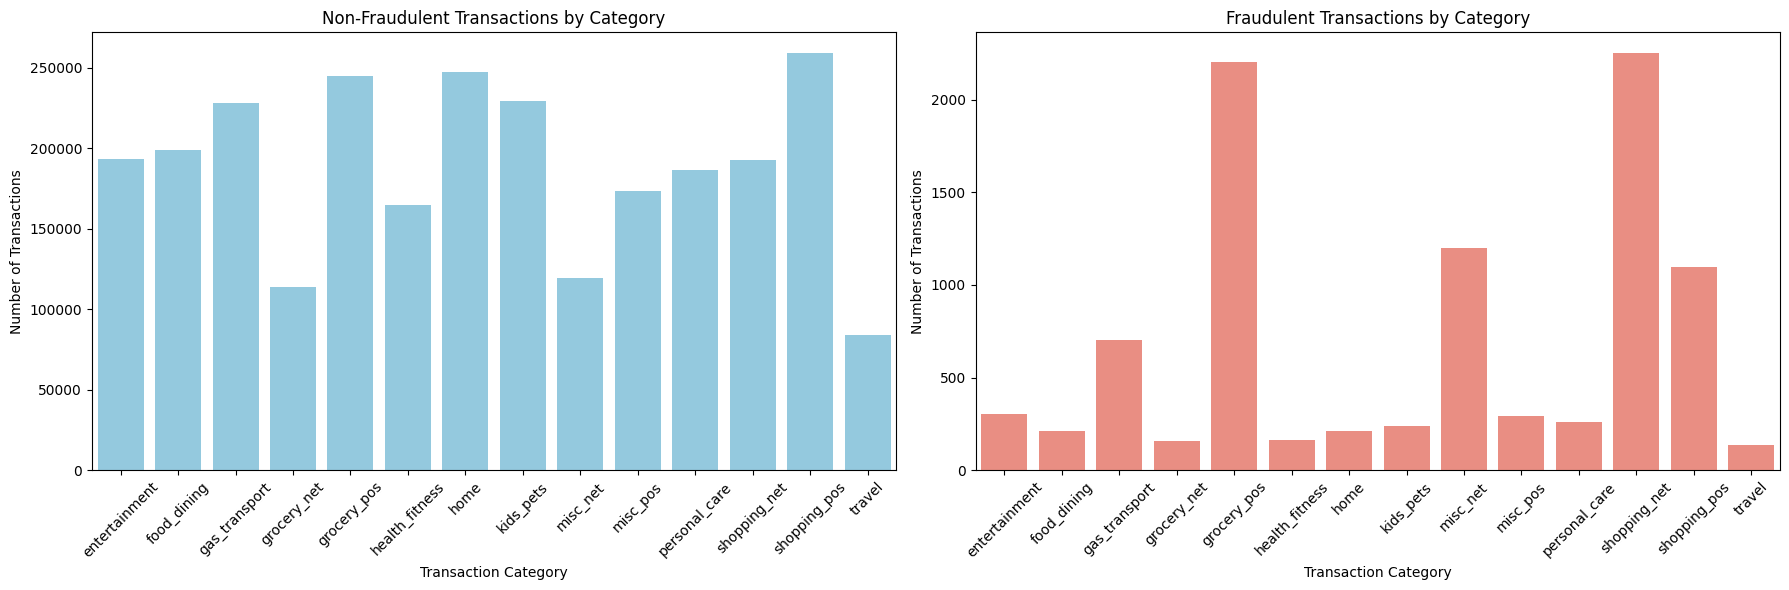

In [16]:
category_fraud = df1.groupby(['category', 'is_fraud']).size().unstack(fill_value=0)

# Create subplots for category analysis
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot Non-Fraudulent Transactions by category
sns.barplot(x=category_fraud.index, y=category_fraud[0], color='skyblue', ax=axes[0])
axes[0].set_title('Non-Fraudulent Transactions by Category')
axes[0].set_xlabel('Transaction Category')
axes[0].set_ylabel('Number of Transactions')
axes[0].tick_params(axis='x', rotation=45)

# Plot Fraudulent Transactions by category
sns.barplot(x=category_fraud.index, y=category_fraud[1], color='salmon', ax=axes[1])
axes[1].set_title('Fraudulent Transactions by Category')
axes[1].set_xlabel('Transaction Category')
axes[1].set_ylabel('Number of Transactions')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Fraudulent transactions by age group

C:\Users\Chloe\AppData\Local\Temp\ipykernel_39372\2943096036.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_fraud = df1.groupby(['age_group', 'is_fraud']).size().unstack(fill_value=0)


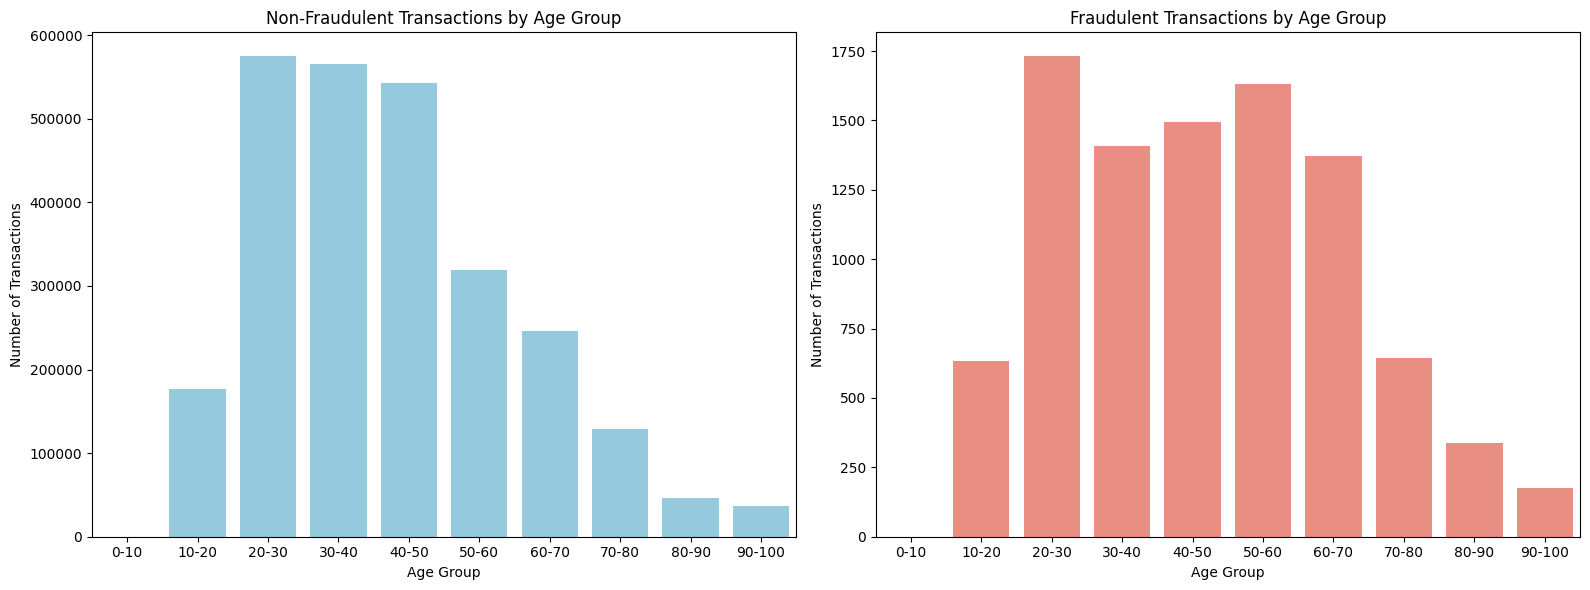

In [17]:
# Age analysis
age_fraud = df1.groupby(['age_group', 'is_fraud']).size().unstack(fill_value=0)

# Create subplots for age analysis
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot Non-Fraudulent Transactions by age
sns.barplot(x=age_fraud.index, y=age_fraud[0], color='skyblue', ax=axes[0])
axes[0].set_title('Non-Fraudulent Transactions by Age Group')
axes[0].set_xlabel('Age Group')
axes[0].set_ylabel('Number of Transactions')

# Plot Fraudulent Transactions by age
sns.barplot(x=age_fraud.index, y=age_fraud[1], color='salmon', ax=axes[1])
axes[1].set_title('Fraudulent Transactions by Age Group')
axes[1].set_xlabel('Age Group')
axes[1].set_ylabel('Number of Transactions')

plt.tight_layout()
plt.show()

### Fraudulent transaction by occupation

**Some occupations are prone to greater risk of fraudulent transactions than others**

Occupations that have a tendency to have strong earning power shows greater proportion of transactions being fraudulent, showing a tendency for fraudsters to target individuals with wealth

                         job  is_fraud  total_count  fraud_percentage
0         Academic librarian        10         1104          0.905797
1      Accommodation manager        11         4381          0.251084
2                 Accountant       109        23052          0.472844
3      Accounting technician        40        10957          0.365063
4                      Actor        46        13156          0.349650
..                       ...       ...          ...               ...
415           Water engineer        18         4381          0.410865
416  Water quality scientist        11         2197          0.500683
417       Wellsite geologist         8         6556          0.122026
418                   Writer        16         4382          0.365130
419             Youth worker        53        20811          0.254673

[420 rows x 4 columns]


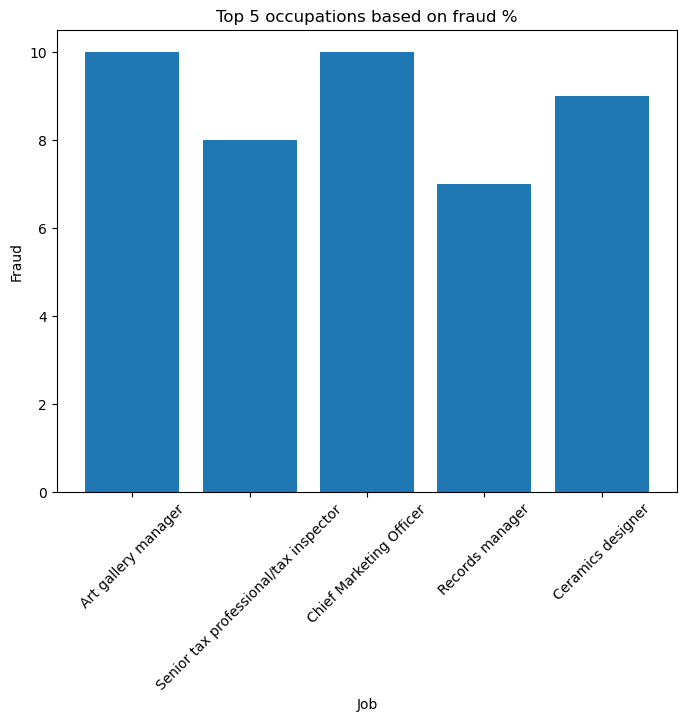

In [ ]:
# x: city_state, y: fraud_count
# fraud count per city_pop, filter to a state to check
fraud_count = df1.groupby('job')['is_fraud'].sum().reset_index()

# Calculate total transactions by job
total_count = df1.groupby('job')['is_fraud'].count().reset_index()
total_count.rename(columns={'is_fraud': 'total_count'},inplace=True)

# Merge fraud count and total count
fraud_percentage = pd.merge(fraud_count, total_count, on='job')


# Calculate percentage of fraud
fraud_percentage['fraud_percentage'] = (fraud_percentage['is_fraud'] / fraud_percentage['total_count']) * 100
top_5=fraud_percentage.sort_values(by='fraud_percentage',ascending=False).head(5)

# Show occupations with the highest % of frauds
print(fraud_percentage)

plt.figure(figsize=(8, 6))
plt.bar('job','is_fraud', data=top_5) 
plt.title('Top 5 occupations based on fraud %')
plt.xlabel('Job')
plt.ylabel('Fraud')
plt.xticks(rotation=45)
plt.show()

### Fraudulent transactions by merchant

Merchants with highest fraud counts:
                  merchant  fraud_count
472         fraud_Reichert          152
416         fraud_Mosciski           94
28          fraud_Baumbach           93
561          fraud_Streich           63
492        fraud_Romaguera           60
254             fraud_Huel           57
197        fraud_Greenholt           56
25   fraud_Bashirian Group           55
18      fraud_Bailey-Morar           55
316          fraud_Kovacek           55
Average fraud per merchant: 14.698907956318253
Median fraud per merchant: 7.0
Standard deviation fraud per merchant: 16.620424686155232


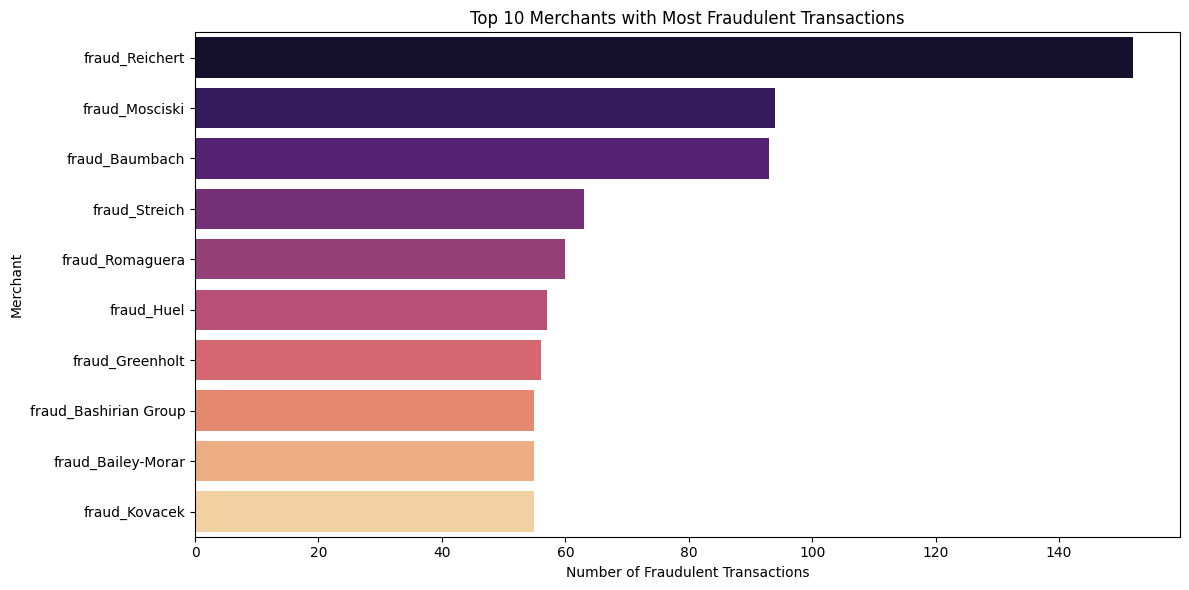


Analysis of top fraud merchants:
Merchant: fraud_Reichert
    Number of fraud transactions: 152
    Number of unique locations: 727
    Number of total customers: 11826
    Number of unique customers: 904
    Number of unique customers in fraud transactions: 140
    Average transaction amount: $75.36
    Most common transaction category: shopping_net
Merchant: fraud_Mosciski
    Number of fraud transactions: 94
    Number of unique locations: 726
    Number of total customers: 8780
    Number of unique customers: 902
    Number of unique customers in fraud transactions: 92
    Average transaction amount: $78.40
    Most common transaction category: grocery_pos
Merchant: fraud_Baumbach
    Number of fraud transactions: 93
    Number of unique locations: 724
    Number of total customers: 14092
    Number of unique customers: 902
    Number of unique customers in fraud transactions: 92
    Average transaction amount: $69.34
    Most common transaction category: shopping_pos


In [18]:
# Top merchants with fraudulent transactions
fraud_count_by_merchant = fraud_filter('merchant').sort_values(by='fraud_count', ascending=False)
print("Merchants with highest fraud counts:")
print(fraud_count_by_merchant.head(10))

# Calculate fraud summary stats for merchants
fraud_summary(fraud_count_by_merchant, 'merchant')

# Visualize top 10 merchants with most fraudulent transactions
top_fraud_merchants = fraud_count_by_merchant.nlargest(10, 'fraud_count')

plt.figure(figsize=(12, 6))
sns.barplot(x='fraud_count', y='merchant', data=top_fraud_merchants, hue='merchant',palette='magma', legend=False)
plt.title('Top 10 Merchants with Most Fraudulent Transactions')
plt.xlabel('Number of Fraudulent Transactions')
plt.ylabel('Merchant')
plt.tight_layout()
plt.show()

# Detailed analysis of top fraud merchants
print("\nAnalysis of top fraud merchants:")
fraud_merchants = list(fraud_count_by_merchant['merchant'].head(3))
for m in fraud_merchants:
    temp = df1[df1['merchant'] == m]
    print(f'Merchant: {m}')
    print(f'    Number of fraud transactions: {temp[temp["is_fraud"] == 1]["ssn"].count()}')
    print(f'    Number of unique locations: {temp["city_state"].nunique()}')
    print(f'    Number of total customers: {temp["ssn"].count()}')
    print(f'    Number of unique customers: {temp["ssn"].nunique()}')
    print(f'    Number of unique customers in fraud transactions: {temp[temp["is_fraud"] == 1]["ssn"].nunique()}')
    avg_transaction_amount = temp['amt'].mean()
    print(f'    Average transaction amount: ${avg_transaction_amount:.2f}')
    most_common_category = temp['category'].mode()[0]  # take the first value
    print(f'    Most common transaction category: {most_common_category}')

In [19]:
least_fraud_m = fraud_count_by_merchant.sort_values(by='fraud_count', ascending=True)
least_fraud_m.head(10)

,merchant,fraud_count
504,fraud_Runte,1
630,fraud_Wuckert-Walter,1
473,fraud_Reichert-Weissnat,1
540,fraud_Skiles-Ankunding,1
554,fraud_Stark-Koss,1
558,fraud_Stokes,1
371,fraud_Little-Gleichner,1
454,fraud_Pouros,1
33,fraud_Bednar Inc,1
508,fraud_Satterfield-Lowe,1


In [20]:
least_fraud_filter = least_fraud_m[least_fraud_m['fraud_count'] == 1]['merchant']

fraud_count_mc = fraud_filter(['merchant', 'ssn'])
fraud_count_mc = fraud_count_mc[fraud_count_mc['merchant'].isin(least_fraud_filter)]
fraud_count_mc.head()

,merchant,ssn,fraud_count
253,fraud_Bahringer-Streich,504-14-2358,1
655,fraud_Bednar Inc,649-60-8105,1
813,fraud_Bins-Howell,437-44-6587,1
1034,fraud_Boyer-Haley,096-65-8934,1
1670,fraud_Deckow-Dare,589-05-8010,1


In [21]:
fraud_count_mc.groupby('ssn')['ssn'].count() 

ssn
059-31-8309    1
069-45-2671    1
096-65-8934    1
136-67-4961    1
162-08-8321    1
193-01-5279    1
206-42-7252    1
242-80-7389    1
297-22-0579    1
437-44-6587    1
452-57-9812    1
504-14-2358    1
546-98-9371    1
552-20-7135    1
581-88-4763    1
589-05-8010    1
601-89-5938    1
603-45-6914    1
627-46-9417    1
649-60-8105    1
755-11-1150    1
766-62-3506    1
808-05-0763    1
832-27-5040    1
855-20-0599    1
860-08-4836    1
877-44-8505    1
Name: ssn, dtype: int64

In [22]:
fraud_count_by_consumers = fraud_filter('ssn').sort_values(by='fraud_count', ascending=False)
fraud_count_by_consumers.head(10)

,ssn,fraud_count
719,648-07-3243,19
744,672-90-6422,18
454,428-32-3432,17
452,422-55-9671,16
485,461-60-7650,16
42,038-71-4270,16
341,311-93-4315,16
268,236-75-8053,16
846,766-62-3506,16
581,535-66-3820,16


In [23]:
least_fraud_c = fraud_count_by_consumers.sort_values(by='fraud_count', ascending=True)
least_fraud_c.head(10)

,ssn,fraud_count
654,590-86-8736,2
638,581-08-0162,2
637,580-38-0878,2
215,182-22-0390,2
548,505-02-6947,2
567,525-56-7036,2
490,465-98-6615,2
151,125-63-8352,2
553,507-88-8724,2
703,630-56-4499,3


### Fraudulent transactions by value